In [1]:
# !pip install vision_transformer_pytorch

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import albumentations as albu
import matplotlib.pyplot as plt
import json
import seaborn as sns
import cv2
import albumentations as albu

# Pre-processing

### Read file, set path

In [3]:
import sys

package_path = '../input/vision-transformer-pytorch/VisionTransformer-Pytorch'
sys.path.append(package_path)

BASE_DIR="../input/cassava-leaf-disease-classification/"
TRAIN_IMAGES_DIR=os.path.join(BASE_DIR,'train_images') # add / to concat

train_df=pd.read_csv(os.path.join(BASE_DIR,'train.csv'))
print(TRAIN_IMAGES_DIR)
print("\ntrain_df:")
print(train_df.head())
print("\nCount of training images {0}".format(len(os.listdir(TRAIN_IMAGES_DIR))))

../input/cassava-leaf-disease-classification/train_images

train_df:
         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

Count of training images 21397


In [4]:
with open(f'{BASE_DIR}/label_num_to_disease_map.json', 'r') as f:
    name_mapping = json.load(f)
    
name_mapping = {int(k): v for k, v in name_mapping.items()}
train_df["class_id"]=train_df["label"].map(name_mapping)
print("new train df: \n", train_df.head())
print("length:", len(train_df))

new train df: 
          image_id  label                             class_id
0  1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1  1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2   100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3  1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4  1000812911.jpg      3         Cassava Mosaic Disease (CMD)
length: 21397


According to the table "train_df", divide the training set into __training set__ and __validation set__.

In [5]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(
    train_df, 
    test_size=0.1,    # 0.1的train data变成vaild data
    random_state=42,
    stratify=train_df.label.values
)


# reset index on both dataframes
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

train_targets = train.label.values

# targets for validation
valid_targets = valid.label.values

# Data Augmentation

## Augmentation Techniques
Use [albumentations](https://albumentations.ai/docs/) to do image pre-processing

In [6]:
from albumentations.pytorch import ToTensorV2

train_augs = albu.Compose([
    albu.RandomResizedCrop(height=384, width=384, p=1.0),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.RandomBrightnessContrast(p=0.5),
    albu.ShiftScaleRotate(p=0.5),
    albu.Normalize(    
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],),
    ToTensorV2(),
])

valid_augs = albu.Compose([
    albu.Resize(height=384, width=384, p=1.0),
    albu.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],),
    ToTensorV2(),
])

## Visualize the Augmentation

In [7]:
def plot_augmentation(image_id,transform):
    plt.figure(figsize=(16,4))
    
    img=cv2.imread(os.path.join(TRAIN_IMAGES_DIR,image_id))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    plt.subplot(1,3,1) # orignal image
    plt.imshow(img)
    plt.axis("off")
    
    plt.subplot(1,3,2) #
    x=transform(image=img)["image"]
    # TODO: swap the order
    plt.imshow(x)
    plt.axis("off")
    
    plt.show()
    
# plot_augmentation(train.iloc[0]['image_id'], train_augs)

# Establish Dataset
Make our own dataset by inheriting the pytorch class: *Dataset*

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
# from efficientnet_pytorch import EfficientNet
import time
import datetime
import copy

## Dataset Class

In [9]:
# Inherit DataSet class and create our own dataset for the Cassava images

class CassavaDataset(Dataset):
    def __init__(self,df:pd.DataFrame,imfolder:str,train:bool = True, transforms=None):
        self.df=df
        self.imfolder=imfolder
        self.train=train
        self.transforms=transforms
        
    def __getitem__(self,index):
        im_path=os.path.join(self.imfolder,self.df.iloc[index]['image_id'])
        x=cv2.imread(im_path,cv2.IMREAD_COLOR)
        x=cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
        
        if(self.transforms):
            x=self.transforms(image=x)['image']
        
        if(self.train):
            y=self.df.iloc[index]['label']
            return x,y
        else:
            return x
        
    def __len__(self):
        return len(self.df)

## Instance CassavaDataset class 
1. train_dataset
2. valid_dataset

In [10]:
train_dataset=CassavaDataset(
    df=train,
    imfolder=TRAIN_IMAGES_DIR,
    train=True,
    transforms=train_augs
)

valid_dataset=CassavaDataset(
    df=valid,
    imfolder=TRAIN_IMAGES_DIR,
    train=True,
    transforms=valid_augs
)

## Creating a Dataloader
Create an iterable Dataloader using the Dataset for use in the training process.

In [11]:
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=4,
    shuffle=True,
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=16,
    num_workers=4,
    shuffle=False,
)

# Model 

In [12]:
# Define CNN
import torch.nn as nn
import torch.nn.functional as F

#  implement a 7 layers fully-connected neural networks with ReLu activation function.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()   # 3 * 384*384 = 442368
        self.fc1 = nn.Linear(442368, 5)        
#         self.fc3 = nn.Linear(128,5)  
        # There are 5 labels

    def forward(self, x):
        x = x.view(-1, 442368)
#         x = F.relu(self.fc1(x))
        x = self.fc1(x)
        return x


net = Net()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
print(device)

cuda


### Optimizer and Loss function

In [13]:
# Define loss function
import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# optimizer and loss function
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
criterion = nn.CrossEntropyLoss()

# train / valid dataset and dataloader
datasets={'train':train_dataset,'valid':valid_dataset}
dataloaders={'train':train_loader,'valid':valid_loader}


# Training

## Train Process

In [14]:
# records array
train_loss_records = []
train_acc_records = []
valid_loss_records = []
valid_acc_records = []

In [15]:
def train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0 # best accuracy
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1), "\n", '-' * 10)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval() # turn off other layers

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels=labels.to(device)

                # Zero out the grads
                optimizer.zero_grad()

                # Forward
                # Track history in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    model=model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # Statistics
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss/len(datasets[phase])
            epoch_acc = running_corrects.double()/len(datasets[phase])
            
            # record loss and accuracy
            if (phase == "train"):
                train_loss_records.append(epoch_loss)
                train_acc_records.append(epoch_acc)
            else:
                valid_loss_records.append(epoch_loss)
                valid_acc_records.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # copy 参数的变量

            print()

    time_elapsed = time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

### Start to train the network

In [16]:
# Train the network
num_epochs=5
train_model(datasets, dataloaders, net, criterion, optimizer, scheduler, num_epochs, device)
   
print('Finished Training')

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)  # save trained model

Epoch 0/4 
 ----------
train Loss: 10.0758 Acc: 0.3799

valid Loss: 8.7869 Acc: 0.3771

Epoch 1/4 
 ----------
train Loss: 11.2531 Acc: 0.3729

valid Loss: 11.2291 Acc: 0.2444

Epoch 2/4 
 ----------
train Loss: 6.0231 Acc: 0.3695

valid Loss: 5.0476 Acc: 0.3846

Epoch 3/4 
 ----------
train Loss: 4.7752 Acc: 0.3677

valid Loss: 4.3157 Acc: 0.3963

Epoch 4/4 
 ----------
train Loss: 4.0633 Acc: 0.3699

valid Loss: 4.0686 Acc: 0.3949

Training complete in 25m 15s
Best val Acc: 0.396262
Finished Training


Draw training process loss/accuracy figure

In [17]:
import matplotlib.pyplot as plt

def plot_trend(title, arr1, arr1_legend, arr2, arr2_legend, x_label, y_label):
    fig, ax = plt.subplots()
    epochs = range(1, len(arr1)+1)
    ax.plot(epochs, arr1, label = arr1_legend)
    ax.plot(epochs, arr2, label = arr2_legend)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend()

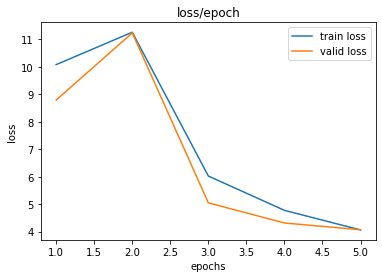

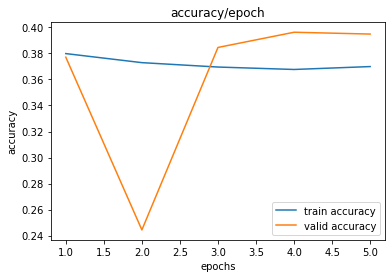

In [18]:
plot_trend("loss/epoch", train_loss_records, "train loss", valid_loss_records, "valid loss", "epochs", "loss")
plot_trend("accuracy/epoch", train_acc_records, "train accuracy", valid_acc_records, "valid accuracy", "epochs", "accuracy")